In [44]:
# Essential libraries
import os
import random
import itertools
from itertools import product, combinations
import multiprocessing

# Numeric computation
import numpy as np
import torch
import scipy  # For linear algebra (e.g., Cholesky decomposition)
from scipy.spatial import ConvexHull, Delaunay # For sampling and NTR
from scipy.optimize import minimize #For projection to the NTR
from scipy.spatial.distance import pdist, squareform #For projection to the NTR
from scipy.special import roots_hermite # Polynomials of the form e^(-x^2)
from scipy.special import roots_hermitenorm # Polynomials of the form e^(-x^(2)/2)

# Gaussian Process Regression (GPR)
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import (Kernel, ScaleKernel, MaternKernel, 
                              GridInterpolationKernel, ProductKernel)
from gpytorch.utils.grid import choose_grid_size
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList  # Correct import for ModuleList (For SKIP)
from gpytorch.variational import (CholeskyVariationalDistribution, 
                                  VariationalStrategy)  # For SVGP
from gpytorch.lazy import MatmulLazyTensor, InterpolatedLazyTensor
from gpytorch.settings import fast_pred_var

# Optimization
import cyipopt
from cyipopt import Problem

# Quasi-Monte Carlo (QMC) and sparse grids
import Tasmanian  # Tasmanian Sparse Grid library
from torch.quasirandom import SobolEngine
import chaospy as cp

# We can save our No-trade-regions (Convex hulls) as .pkl files
import pickle
    #Save
    # with open("convex_hulls_array.pkl", "wb") as file:
    #     pickle.dump(convex_hulls, file)
    #Open
    # with open("convex_hulls_array.pkl", "rb") as file:
    #     loaded_hulls = pickle.load(file)


# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
import scienceplots  # For custom style based on science plots

# Parallel processing
from joblib import Parallel, delayed

# Logging configuration
import logging
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Random seed setup
random_seed = 121001
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
multiprocessing.set_start_method('spawn', force=True)

In [45]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#094a84','#cc2300', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#094a84','#cc2300', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 11
    mpl.rcParams['axes.titlesize'] = 11
    mpl.rcParams['axes.labelsize'] = 11
    mpl.rcParams['legend.fontsize'] = 11

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.color'] = '#e2e3e4'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'

    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

In [46]:
def load_ntr_array_from_file(filename):
    """
    Loads the NTR array from a pickle file.

    Parameters:
    - filename: The name of the file to load.

    Returns:
    - The NTR array (list of ConvexHull objects or None).
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    # Construct the full file path
    full_filename = os.path.join("NTRs", filename)

    with open(full_filename, "rb") as file:
        NTR = pickle.load(file)
    print(f"NTR array loaded from {full_filename}")
    return NTR

Schober_Parameters = False #Parameters of Schober 2020 
Cai_Judd_Identical = False #Assumes a correlation coefficent of 0
Cai_Judd_High_Correlation = True #Assumes a correlation coefficient of 0.75
include_consumption = False
tau = 0.005
D = 2

# Choose the parameter prefix based on the active parameter set
if Schober_Parameters:
    filename_prefix = "Schober_Parameters"
elif Cai_Judd_Identical:
    filename_prefix = "Cai_Identical"
elif Cai_Judd_High_Correlation:
    filename_prefix = "Cai_High_Correlation"
else:
    filename_prefix = "Unknown_Parameters"

if include_consumption:
    consumption = "_with_consumption"
else:
    consumption = "_no_consumption"

# Construct the full file path
filename = f"NTR_{filename_prefix}_d{D}_tau_{tau}_{consumption}.pkl"

NTR = load_ntr_array_from_file(f"{filename}")

NTR array loaded from NTRs/NTR_Cai_High_Correlation_d2_tau_0.005__no_consumption.pkl


In [47]:
# Function for the Merton point (No costs solution)
def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1.0 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star


if Schober_Parameters:
    gamma = 3.5
    r = np.log(1.0408)
    mu = np.array([0.0572, 0.0638, 0.07, 0.0764, 0.0828])
    Sigma = np.array([
                    [0.0256, 0.00576, 0.00288, 0.00176, 0.00096], 
                    [0.00576, 0.0324, 0.0090432, 0.010692, 0.01296],
                    [0.00288, 0.0090432, 0.04, 0.0132, 0.0168],
                    [0.00176, 0.010692, 0.0132, 0.0484, 0.02112],
                    [0.00096, 0.01296, 0.0168, 0.02112, 0.0576]
                    ])
if Cai_Judd_Identical:
    gamma = 3.0
    r = np.log(np.round(np.exp(0.03),4))
    mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
    Sigma = np.array([
                    [0.04, 0.00, 0.00, 0.00, 0.00], 
                    [0.00, 0.04, 0.00, 0.00, 0.00],
                    [0.00, 0.00, 0.04, 0.00, 0.00],
                    [0.00, 0.00, 0.00, 0.04, 0.00],
                    [0.00, 0.00, 0.00, 0.00, 0.04]
                    ])
if Cai_Judd_High_Correlation:
    gamma = 3.0
    r = np.log(np.round(np.exp(0.03),4))
    mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
    Sigma = np.array([
                    [0.04, 0.03, 0.03, 0.03, 0.03], 
                    [0.03, 0.04, 0.03, 0.03, 0.03],
                    [0.03, 0.03, 0.04, 0.03, 0.03],
                    [0.03, 0.03, 0.03, 0.04, 0.03],
                    [0.03, 0.03, 0.03, 0.03, 0.04]
                    ])

def select_mu_sigma(mu, Sigma, D):
    """
    Selects the first D elements from mu and the corresponding D x D submatrix from Sigma.
    """
    selected_mu = mu[:D]
    selected_Sigma = Sigma[:D, :D]
    return selected_mu, selected_Sigma

D = 2
mu, Sigma = select_mu_sigma(mu, Sigma, D)
# Compute the Merton point
merton_p = MertonPoint(mu, Sigma, r, gamma)
merton_p

array([0.19026609, 0.19026609])

# Plot NTR at a single time point

Figure saved to ../Speciale dokumentet/Figures/NTR_Cai_High_Correlation_d2_tau_0.005__no_consumption_t_0.png


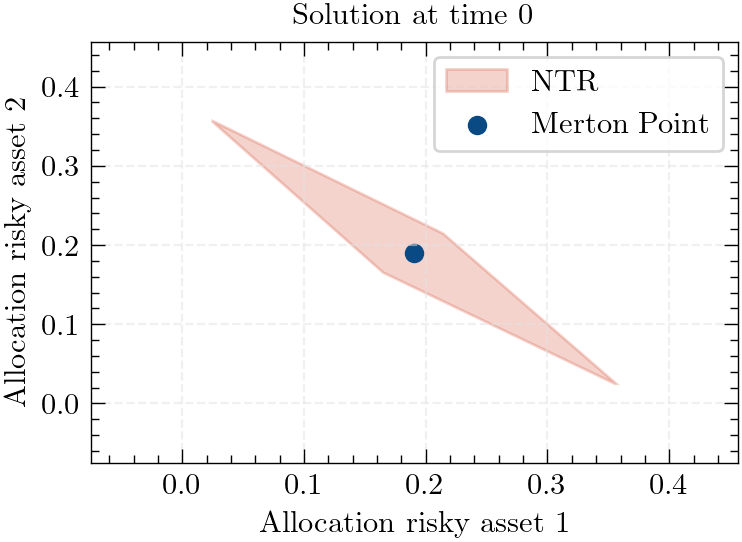

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

vertices = NTR[0].points  # Vertices are stored in the 'points' attribute of ConvexHull
D = vertices.shape[1]  # Dimension of the state space
# Define the function to save the figure
def save_figure_with_filename(base_filename, t, output_folder='../Speciale dokumentet/Figures'):
    """
    Saves the figure with the given filename structure and adds '_t_{t}'.

    Parameters:
    - base_filename: The base filename to use.
    - t: The time period to append to the filename.
    - output_folder: The folder to save the figure in.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the full filename
    figure_filename = f"{base_filename}_t_{t}.png"
    full_path = os.path.join(output_folder, figure_filename)

    # Save the figure
    plt.savefig(full_path)
    print(f"Figure saved to {full_path}")

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(4,3),dpi=200)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            plt.title(f'Solution at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point')
            plt.legend()
            plt.xlabel('Allocation risky asset 1')
            plt.ylabel('Allocation risky asset 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)
            save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')

        elif D == 3:
                # 3D plot
                ax = plt.axes(projection='3d')
                ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=colors[1],alpha=0.2,s=10,marker='*')
                
                # Plot only the convex hull surfaces without edges
                faces = hull.simplices
                poly3d = [[vertices[face] for face in simplex] for simplex in faces]
                ax.add_collection3d(Poly3DCollection(poly3d, facecolors=colors[1], edgecolor='none', alpha=0.2))
                
                ax.scatter(merton_p[0], merton_p[1], merton_p[2], color=colors[0], s=75, label='Merton Point')
                ax.legend()
                ax.set_xlabel('Allocation risky asset 1')
                ax.set_ylabel('Allocation risky asset 2')
                ax.set_zlabel('Allocation risky asset  3')
                plt.title(f'Solution at time {t}')
                x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
                y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
                z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()
                ax.set_xlim(x_min - 0.05, x_max + 0.05)
                ax.set_ylim(y_min - 0.05, y_max + 0.05)
                ax.set_zlim(z_min - 0.05, z_max + 0.05)  
                ax.view_init(elev=25, azim=50)  # Adjust elev and azim for desired viewing angle
                save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

if D < 4 and D > 0:
    t = len(NTR) - len(NTR)
    # Example: Plot NTR at time t=1
    plot_ntr_at_time(NTR,t)